In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

from sklearn.datasets import load_breast_cancer
from xgboost import XGBClassifier, plot_tree
import graphviz

import random

## Import data set
Using the Scikit Learn Breast Cancer data

In [17]:
cancer = load_breast_cancer()

df = pd.DataFrame(cancer['data'])
df.columns = cancer['feature_names']
df['target'] = cancer['target']

## Pull these values for later use
n_features = cancer['feature_names'].shape[0]
n_instances = df.shape[0]

## The random samples are for demonstrative purposes

#### Take a random sampling of the input features

In [18]:
input_features = list(cancer['feature_names'][random.sample(range(n_features), random.randint(2, n_features))])

print(f'{len(input_features)} of the {n_features} features were selected from the data set.')

7 of the 30 features were selected from the data set.


#### Take a random sample of the instances

In [19]:
df = df[input_features + ['target']].sample(n= random.randint(50, df.shape[0]))

print(f'{df.shape[0]} of the {n_instances} instances were selected from the data set.')

180 of the 569 instances were selected from the data set.


## Calculate the initial prediction from the target rate
- XGBoost's base_score has a default value of 0.5
- The target rate will be used for demonstrative purposes
#### Include the initial prediction and the calculated residuals in the dataframe

In [20]:
prob_baseline = df.target.sum() / df.shape[0]
print(f'User defined base score: {prob_baseline}')

df['prob'] = prob_baseline
df['residual'] = df.target - df.prob

User defined base score: 0.6388888888888888


In [21]:
df.head()

,worst perimeter,worst concavity,texture error,concavity error,mean compactness,radius error,worst smoothness,target,prob,residual
251,83.12,0.08105,0.8429,0.01245,0.05991,0.3927,0.1183,1,0.638889,0.361111
71,62.56,0.14340,0.8522,0.05671,0.15310,0.5262,0.1207,1,0.638889,0.361111
34,132.70,0.52740,0.6857,0.02664,0.15590,0.3340,0.1446,0,0.638889,-0.638889
138,121.40,0.33550,1.4520,0.06577,0.13050,1.2960,0.1411,0,0.638889,-0.638889
84,87.78,0.22670,1.2550,0.02007,0.07165,0.2271,0.1377,1,0.638889,0.361111


## Functions
- XGBoost utilizes a similarity metric for feature and split identification
- Similarity is the square of the sum of residuals in a leaf node divided by the previous probabilities
    - For the initial tree construction, the previous probability is the baseline
    - XGBoost's default baseline value is 0.5
- The leaf outputs are calculated as the sum of residuals in a leaf node divided by the previous probabilities

In [22]:
def calculate_similarity(x, reg_lambda):
    return((x.residual.sum()**2) / ((x.prob * (1 - x.prob)).sum() + reg_lambda))

def calculate_output(x, reg_lambda):
    return((x.residual.sum()) / ((x.prob * (1 - x.prob)).sum() + reg_lambda))

def find_optimal_cutpoint(df_in, input_features, reg_lambda):
    
    if df_in.residual.nunique() == 1:
        opt_feature = None
        opt_cut = None
        left_output = calculate_output(df_in, reg_lambda= reg_lambda)
        right_output = np.nan
    
    else:
        optimal_by_feature = {}
        gains = {}
        for feat in input_features:
            temp_df = df_in[[feat, 'prob', 'residual']].sort_values(by= feat)

            cutpoints = []
            LT_SIMs = []
            GTE_SIMs = []

            feat_unique_values = np.sort(temp_df[feat].unique())

            for i in np.arange(0, feat_unique_values.shape[0] - 1, 1):
                cutpoint = feat_unique_values[i:i+2].mean()
                cutpoints.append(cutpoint)

                LT = temp_df[temp_df[feat] < cutpoint]

                LT_SIMs.append(
                    calculate_similarity(x= LT, reg_lambda= reg_lambda)
                )


                GTE = temp_df[temp_df[feat] >= cutpoint]

                GTE_SIMs.append(
                    calculate_similarity(x= GTE, reg_lambda= reg_lambda)
                )

                similarity_gain = np.array(LT_SIMs) + np.array(GTE_SIMs) - calculate_similarity(x= temp_df, reg_lambda= reg_lambda)

                optimal_by_feature[feat] = {'gain':similarity_gain[similarity_gain.argmax()], 
                                            'cutpoint':cutpoints[similarity_gain.argmax()]
                                           }

                gains[feat] = ({'data': pd.DataFrame({'cutpoint':cutpoints,
                                                      'gain':similarity_gain}),
                                            'opt_cutpoint':cutpoints[similarity_gain.argmax()]
                                           })

        opt_cost_by_feature = pd.DataFrame(optimal_by_feature)
        opt_feature = opt_cost_by_feature.loc['gain'].idxmax()
        opt_cut = opt_cost_by_feature[opt_feature]['cutpoint']

        ## Calculate the output value for each leaf
        left_output = calculate_output(df_in[df_in[opt_feature] < opt_cut], reg_lambda= reg_lambda)
        right_output = calculate_output(df_in[df_in[opt_feature] >= opt_cut], reg_lambda= reg_lambda)

    
    return(opt_feature, opt_cut, left_output, right_output)
        

#### Identify Root node feature and split point

In [23]:
reg_lambda = 1

In [24]:
root_feature, root_cut, root_l_out, root_r_out = \
find_optimal_cutpoint(df_in= df, input_features= input_features, reg_lambda= reg_lambda)

#### With depth = 2, identify the left and right node feature and split point

In [25]:
left_feature, left_cut, left_l_out, left_r_out = \
find_optimal_cutpoint(df_in= df[df[root_feature] < root_cut], input_features= input_features, reg_lambda= reg_lambda)

In [26]:
right_feature, right_cut, right_l_out, right_r_out = \
find_optimal_cutpoint(df_in= df[df[root_feature] >= root_cut], input_features= input_features, reg_lambda= reg_lambda)

#### With depth = 3, identify the left and right node feature and split point for each previous left and right node

In [27]:
left_left_feature, left_left_cut, left_left_l_out, left_left_r_out = \
find_optimal_cutpoint(df_in= df[(df[root_feature] < root_cut) & (df[left_feature] < left_cut)], 
                      input_features= input_features, reg_lambda= reg_lambda)

In [28]:
left_right_feature, left_right_cut, left_right_l_out, left_right_r_out = \
find_optimal_cutpoint(df_in= df[(df[root_feature] < root_cut) & (df[left_feature] >= left_cut)], 
                      input_features= input_features, reg_lambda= reg_lambda)

In [29]:
right_left_feature, right_left_cut, right_left_l_out, right_left_r_out = \
find_optimal_cutpoint(df_in= df[(df[root_feature] >= root_cut) & (df[right_feature] < right_cut)], 
                      input_features= input_features, reg_lambda= reg_lambda)

In [30]:
right_right_feature, right_right_cut, right_right_l_out, right_right_r_out = \
find_optimal_cutpoint(df_in= df[(df[root_feature] >= root_cut) & (df[right_feature] >= right_cut)], 
                      input_features= input_features, reg_lambda= reg_lambda)

#### Aggregate the leaf node output values and scale by learning rate

In [31]:
learn_rate = 0.1

leaf_node_outputs = np.array([left_left_l_out, left_left_r_out, left_right_l_out, left_right_r_out,
                              right_left_l_out, right_left_r_out, right_right_l_out, right_right_r_out]) * learn_rate

In [32]:
leaf_node_outputs

array([ 0.1431231 ,  0.00492476, -0.14833393,  0.06402189,  0.02934169,
       -0.05191223, -0.25702882,         nan])

#### Calculate the log(Odds) predictions

In [33]:
log_odds_predictions = np.log(prob_baseline / (1 - prob_baseline)) + leaf_node_outputs

In [34]:
log_odds_predictions

array([0.71366796, 0.57546962, 0.42221093, 0.63456675, 0.59988655,
       0.51863263, 0.31351603,        nan])

Root Feature and Split: ('worst perimeter', 113.75)
Left Feature and Split: ('worst concavity', 0.46225)
Left Left Feature and Split: ('worst perimeter', 112.85)
Left Right Feature and Split: ('texture error', 1.2005)
Right Feature and Split: ('worst concavity', 0.21805000000000002)
Right Left Feature and Split: ('worst perimeter', 121.19999999999999)
Right Right Feature and Split: (None, None)
Output Values: [ 0.1431231   0.00492476 -0.14833393  0.06402189  0.02934169 -0.05191223
 -0.25702882         nan]


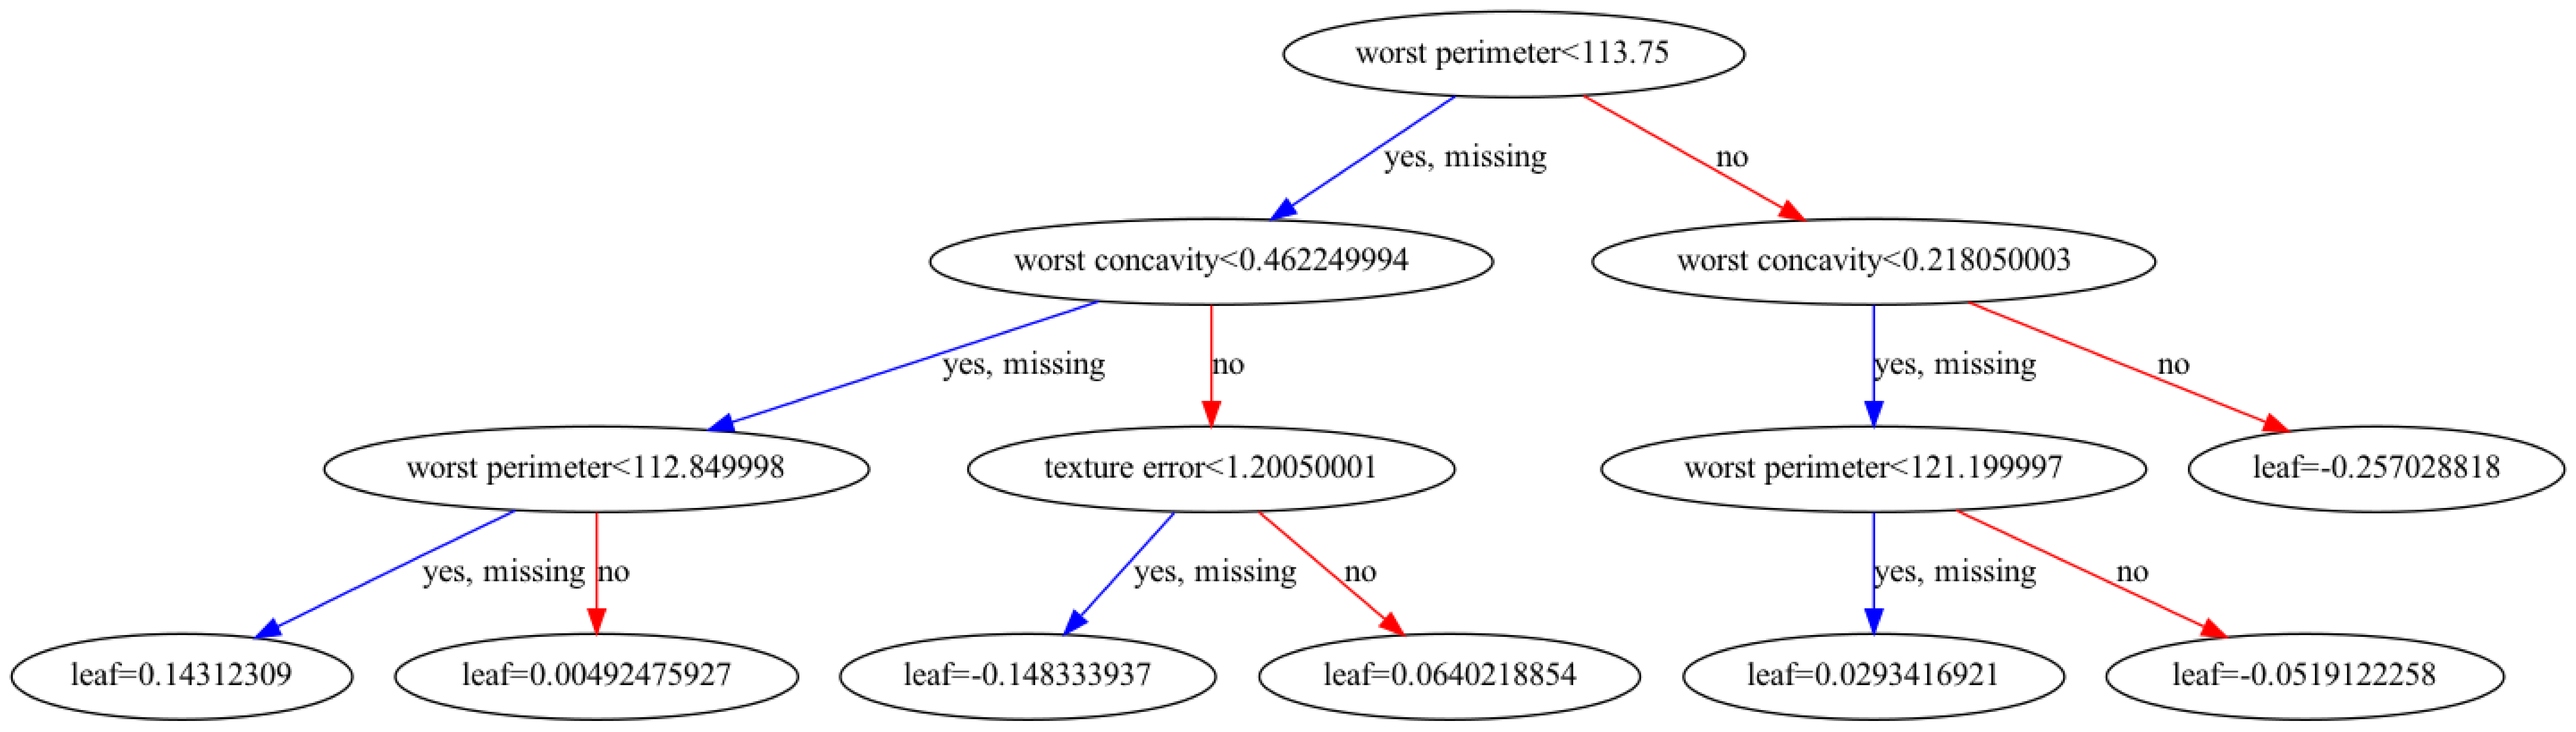

In [35]:
X = df[input_features]
y = df.target

xgb_clf = \
XGBClassifier(max_depth= 3, 
              learning_rate= learn_rate, 
              n_estimators= 1,
              gamma= 0,
              min_child_weight= 0,
              reg_alpha= 0,
              reg_lambda= reg_lambda,
              base_score= prob_baseline)
xgb_clf.fit(X, y)

plot_tree(xgb_clf, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
#plt.show()

print(f'Root Feature and Split: {root_feature, root_cut}')
print(f'Left Feature and Split: {left_feature, left_cut}')
print(f'Left Left Feature and Split: {left_left_feature, left_left_cut}')
print(f'Left Right Feature and Split: {left_right_feature, left_right_cut}')
print(f'Right Feature and Split: {right_feature, right_cut}')
print(f'Right Left Feature and Split: {right_left_feature, right_left_cut}')
print(f'Right Right Feature and Split: {right_right_feature, right_right_cut}')
print(f'Output Values: {leaf_node_outputs}')

## Calculate probabilities

#### Probabilities from manually constructed model

In [36]:
np.sort(np.unique(np.exp(log_odds_predictions) / (1 + np.exp(log_odds_predictions))))

array([0.57774325, 0.60401218, 0.62682797, 0.6400243 , 0.64563035,
       0.65352424, 0.67121114,        nan])

#### Unique probabilites from XGBoost model

In [37]:
np.sort(np.unique(xgb_clf.predict_proba(X)[:, 1]))

array([0.57774323, 0.6040122 , 0.62682796, 0.6400243 , 0.64563036,
       0.6535242 , 0.6712112 ], dtype=float32)